<a href="https://colab.research.google.com/github/ush-naaa/DevHUB/blob/main/DEC/Task%203/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from prophet import Prophet

##**Load Dataset**



In [ ]:
df = pd.read_csv('household_power_consumption.csv',
                 na_values=['?'],
                 low_memory=False)

# Combine Date and Time into a single datetime column
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Set the new datetime column as the index
df.set_index('dt', inplace=True)

# Clean up unnecessary columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

print("Dataset Loaded Successfully. Shape:", df.shape)

Dataset Loaded Successfully. Shape: (1048575, 7)


In [ ]:
print(df.head())

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

##**Preprocessing & Resampling**

In [ ]:
df_hourly = df['Global_active_power'].resample('h').mean()

df_hourly = df_hourly.interpolate(method='linear')

print("Resampled Hourly Shape:", df_hourly.shape)


Resampled Hourly Shape: (17477,)


##**Exploratory Data Analysis (EDA)**


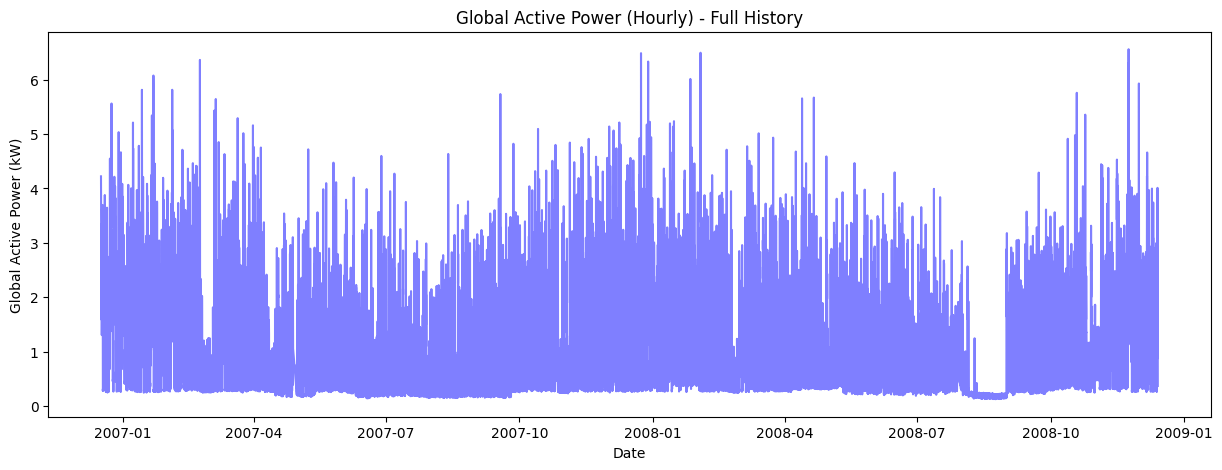

In [ ]:
# 1. Visualizing the entire time series
plt.figure(figsize=(15, 5))
plt.plot(df_hourly.index, df_hourly, color='blue', alpha=0.5)
plt.title('Global Active Power (Hourly) - Full History')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.show()

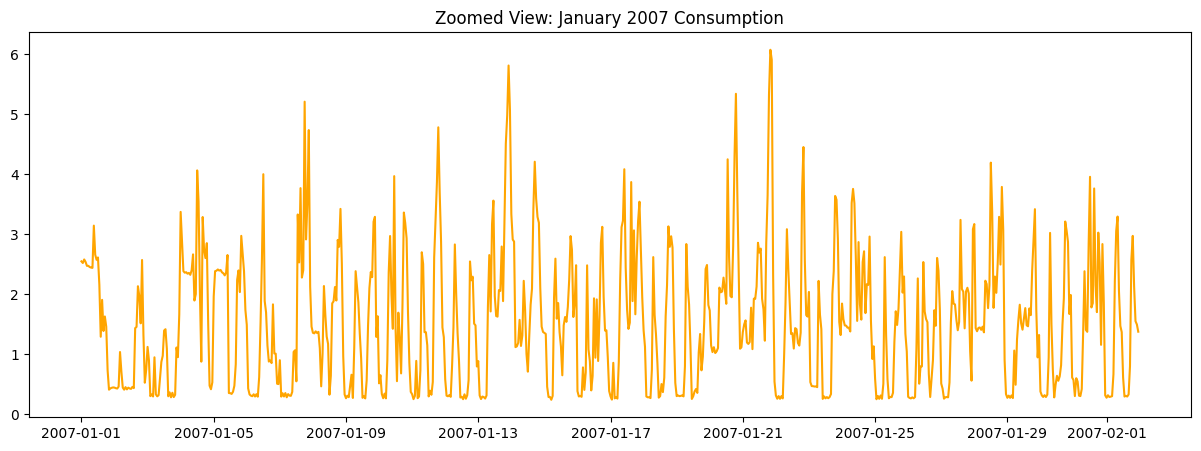

In [ ]:
# 2. Visualizing a smaller slice to see daily patterns
plt.figure(figsize=(15, 5))
subset = df_hourly.loc['2007-01-01':'2007-02-01']
plt.plot(subset.index, subset, color='orange')
plt.title('Zoomed View: January 2007 Consumption')
plt.show()

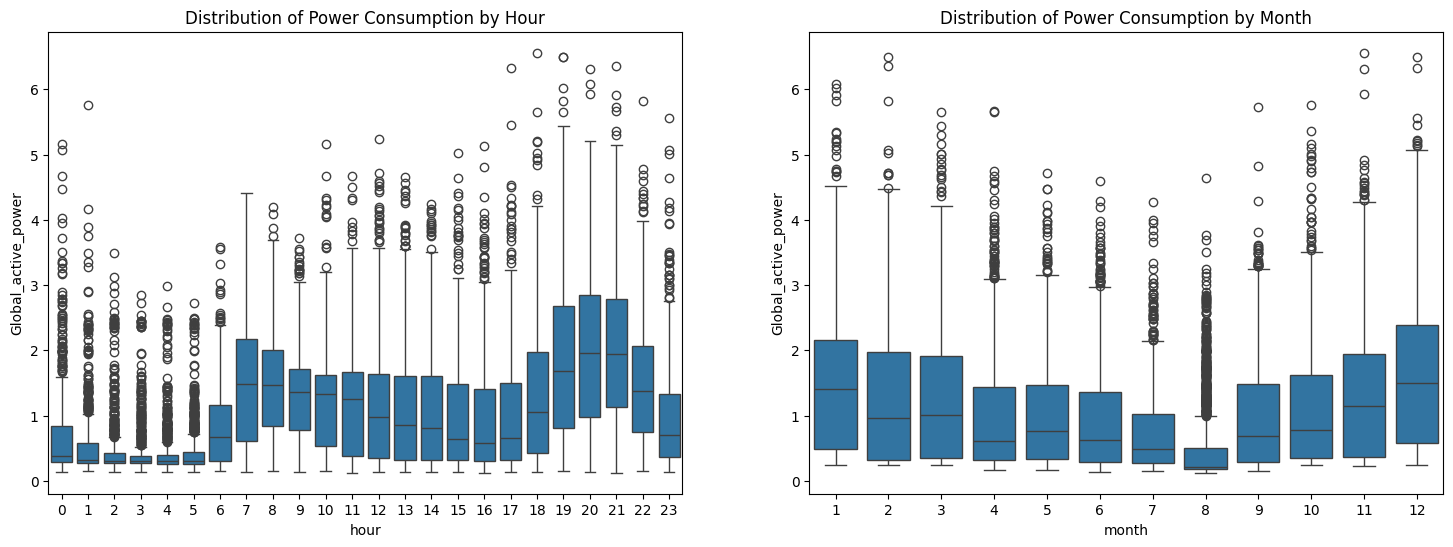

In [ ]:
# 3. Seasonal Patterns (Boxplots)
df_eda = df_hourly.to_frame(name='Global_active_power')
df_eda['hour'] = df_eda.index.hour
df_eda['month'] = df_eda.index.month

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(x='hour', y='Global_active_power', data=df_eda, ax=axes[0])
axes[0].set_title('Distribution of Power Consumption by Hour')

sns.boxplot(x='month', y='Global_active_power', data=df_eda, ax=axes[1])
axes[1].set_title('Distribution of Power Consumption by Month')
plt.show()

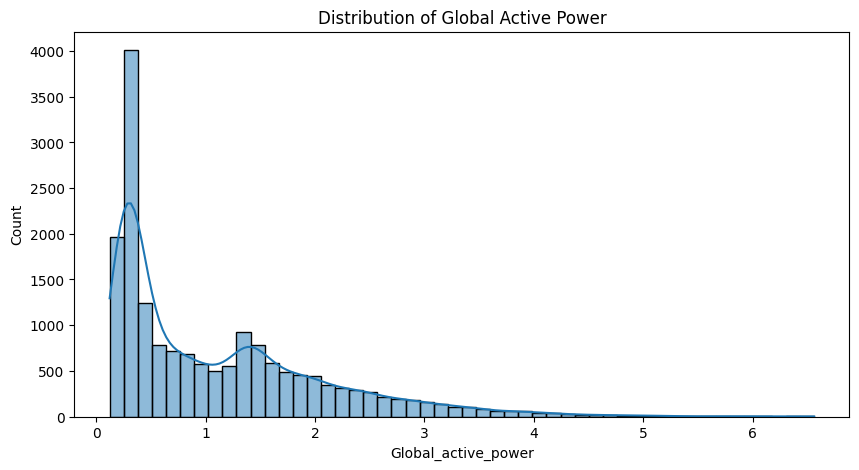

In [ ]:
# 4. Distribution of the Target Variable
plt.figure(figsize=(10, 5))
sns.histplot(df_hourly, bins=50, kde=True)
plt.title('Distribution of Global Active Power')
plt.show()

##**Train-Test Split**

In [ ]:
# Split into Train and Test (Last 7 days for testing)
test_days = 7
test_size = 24 * test_days
train = df_hourly.iloc[:-test_size]
test = df_hourly.iloc[-test_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 17309, Test size: 168


##**Model 1: ARIMA (Statistical Baseline)**

In [ ]:
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(test))

arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"ARIMA RMSE: {arima_rmse:.4f}")

ARIMA RMSE: 1.0424


##**Model 2: XGBoost (Machine Learning Approach)**


In [ ]:
def create_features(data):
    df = pd.DataFrame(data)
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_24'] = df['Global_active_power'].shift(24)

    return df.dropna()

df_features = create_features(df_hourly)

train_ml = df_features.iloc[:-test_size]
test_ml = df_features.iloc[-test_size:]

X_train = train_ml.drop('Global_active_power', axis=1)
y_train = train_ml['Global_active_power']
X_test = test_ml.drop('Global_active_power', axis=1)
y_test = test_ml['Global_active_power']

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=50)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

XGBoost RMSE: 0.5736


##**Model 3: Prophet**

In [ ]:
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']

m = Prophet()
m.fit(prophet_df)

future = m.make_future_dataframe(periods=len(test), freq='h')
forecast = m.predict(future)

# Extract predictions for test period
prophet_pred = forecast['yhat'].iloc[-len(test):].values
prophet_rmse = np.sqrt(mean_squared_error(test, prophet_pred))
print(f"Prophet RMSE: {prophet_rmse:.4f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Prophet RMSE: 0.7305


##**Comparison Visualization**

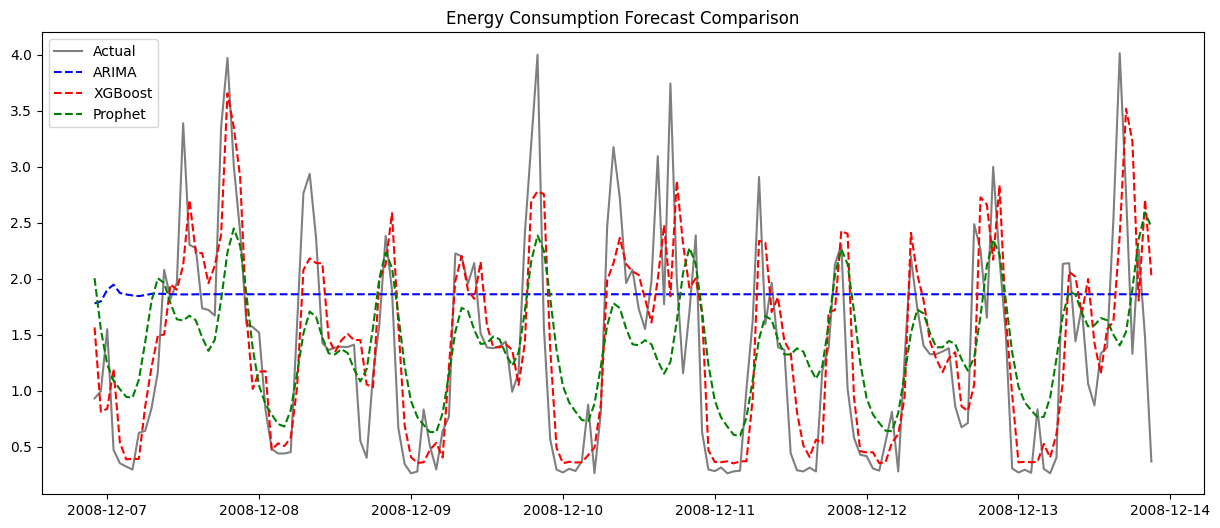

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test.index, test, label='Actual', color='black', alpha=0.5)
plt.plot(test.index, arima_forecast, label='ARIMA',color='blue', linestyle='--')
plt.plot(test.index, xgb_pred, label='XGBoost',color='red', linestyle='--')
plt.plot(test.index, prophet_pred, label='Prophet',color='green', linestyle='--')

plt.title('Energy Consumption Forecast Comparison')
plt.legend()
plt.show()

In [ ]:
print("-" * 30)
print("Final Evaluation Metrics:")
print(f"ARIMA RMSE:   {arima_rmse:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"Prophet RMSE: {prophet_rmse:.4f}")
print("-" * 30)

------------------------------
Final Evaluation Metrics:
ARIMA RMSE:   1.0424
XGBoost RMSE: 0.5736
Prophet RMSE: 0.7305
------------------------------
